# Colab setup

Preparazione dell'ambiente di esecuzione del colab notebook. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd /content/drive/MyDrive/Colab_yelp/Yelp-Data-Analysis

In [ ]:
! git pull

In [ ]:
! pip install -q -U "tensorflow-text==2.8.*"
! pip install -q tf-models-official==2.7.0
! pip install keras-tuner

# TASK 3

Ogni recensione lasciata sul sito Yelp può ricevere feedback da altri utenti, che possono contrassegnarla come *funny*, *cool* e/o *useful*.

L'obbiettivo del presente studio è quello di valutare diverse tecniche di machine learning fini alla predizione dell'utilità di una review.
Il problema è stato trattato in due modi differenti:
- Problema di regressione: predizione numero di feedback *useful*
- Problema di classificazione: predizione livello (classe) di utilità:
    - 'not useful' (voti 'useful' <=5 )
    - 'moderetely useful' (5 < voti 'moderetely useful' <=25 )
    - 'extremely useful' (25 < voti 'extremely useful')

In [2]:
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Embedding
from official.nlp import optimization

# from libraries import data_handler
from libraries import data_handler
from libraries.dataset import Dataset

import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow as tf
import keras_tuner as kt
import tensorflow_text
import pandas as pd

import libraries.preprocessing_utils as prep_utils
import libraries.models_builders as models_builders
import libraries.filenames_generator as filenames  
import constants as const

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\aless_vzq3wiu\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aless_vzq3wiu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aless_vzq3wiu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

print(tf.test.gpu_device_name())

Num GPUs Available:  1
/device:GPU:0


# Data analysis

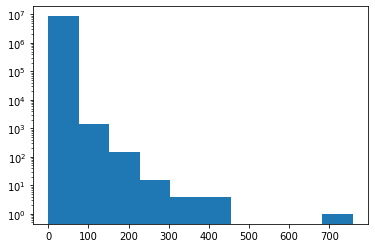

In [ ]:
data = data_handler.load_dataset('review')

plt.hist(data['useful'], log=True)
plt.show()

In [ ]:
data['usefulness'].value_counts()

not useful           8248608
moderately useful     369176
extremely useful       17619
Name: usefulness, dtype: int64

# Data retrieving

Caricamento del dataset contenente le reviews.  

In [5]:
review_data = Dataset('review', 'usefulness')

colums_to_keep = ['review_id','user_id','business_id','stars','useful','funny','cool','text','date','sentiment']

# 30_000 elements for each class
review_data.split(colums_to_keep, 'usefulness', val_size=0.1, test_size=0.1, n_samples=30_000)

Getting review data balanced respect usefulness values
	Balanced dataset doesn't already exists, generating ./data/balanced_review_usefulness.csv
	Unpickling./data/pickled/review.pkl...
	File unpickled in 1.9831 minutes
Dataset splitted into train (62095 samples), val (7762 samples), test (7762 samples)
./data/balanced_review_usefulness_train.csv created
./data/balanced_review_usefulness_val.csv created
./data/balanced_review_usefulness_test.csv created


# Data preprocessing comune

In [4]:
prep_train_data = prep_utils.preprocess_texts(review_data.train_data[0]['text'], path= filenames.picked_cleaned_sentences(
        "train", "task3"))

prep_test_data = prep_utils.preprocess_texts(review_data.test_data[0]['text'], path= filenames.picked_cleaned_sentences(
        "test", "task3"))

prep_val_data = prep_utils.preprocess_texts(review_data.val_data[0]['text'], path= filenames.picked_cleaned_sentences(
        "val", "task3"))


Loading pickled cleaned sentences data from ./data/pickled/task3_train_cleaned_sentences.pkl...
Loading pickled cleaned sentences data from ./data/pickled/task3_test_cleaned_sentences.pkl...
Loading pickled cleaned sentences data from ./data/pickled/task3_val_cleaned_sentences.pkl...


# Training dei modelli
Per i modelli predittivi basati unicamente sul testo come input, sono state testate due tecniche di deep learning:
- **LSTM**
- **BERT**

ed altre classiche di machine learning:
- SVM
- RANDOM FOREST

le prime due architetture sono state utilizzate per la risoluzione del problema visto come di classificazione e le altre per entrambi i problemi (regressione e classificazione).

<!-- Riguardo i modelli utilizzati invece con un insieme più ampio di features, sono stati scelti i seguenti modelli:
- random forest
- svm -->

## Classificatori
### LSTM    

Sono state testate diverse architetture delle RNN di tipo LSTM, al fine di trovare la combinazione di iperparametri che rendono le migliori performance.

Riguardo il preprocessing aggiuntivo sui dati, è stato utilizzato un tokenizer specifico, il quale restituisce per ogni review un vettore contenente gli indici delle parole nel dizionario (estratto dalla collezione di reviews).

Tali indici sono fondamentali per il recupero delle word embedding corrispondenti alle parole delle reviews, azione che avviene nel layer di tipo Embedding impostato come primo layer della rete neurale.


In [4]:
tokenizer = prep_utils.get_tokenizer(review_data.train_data[0]['text'])

train_tokens = prep_utils.get_set_tokens(
    review_data.train_data[0]['text'], tokenizer, set='train', task='task3')

test_tokens = prep_utils.get_set_tokens(
    review_data.test_data[0]['text'], tokenizer, set='test', task='task3')

val_tokens = prep_utils.get_set_tokens(
    review_data.val_data[0]['text'], tokenizer, set='val', task='task3')

Esistono diverse metodologie per la definizione dei word vectors, dal training di reti come Word2Vec all'utilizzo di mapping già pre-trained

Nel caso di questo studio è stato scelto di creare un'embedding matrix a partire da un mapping già esistente, nello specifico quello messo a disposizione da Glove e addestrato su una grande mole di dati testuali estratti da twitter.
Sulla base di questo mapping, sono stati estratti, ed inseriti in una matrice, i vettori delle parole presenti nel dizionario e, se non presenti, queste sono stati rappresentati come 0-vector.

In [5]:
e_matrix = prep_utils.get_embedding_matrix(const.word_embedding_filepath, 'task3',
                                            tokenizer, len(tokenizer.index_word)+1)

word_vector_dim = 100

vocab_size = len(tokenizer.word_index)+1
max_length = len(max(train_tokens, key=len))

embedding_layer = Embedding(vocab_size, word_vector_dim,
                            embeddings_initializer=Constant(e_matrix), trainable=False)

Loading pickled embedding matrix from ./data/embedding/task3_embedding_matrix.npy...
...embedding matrix loaded


Inizio fase di tuning degli iperparametri. 

Gli iperparametri testati sono:
- numero di units (dimensione del vettore delle celle e hidden states)
- percentuale di dropout
- learning rate

Il training è gestito utilizzando la tecnica dell'early stopping, definita dalla seguente callback, che termina il training dopo 5 epoche prive di miglioramenti.

In [6]:
# define custom callbacks
stop_early_cb = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)

In [ ]:
project_name = "task3_lstm_classifier_adam_32"

builder = models_builders.get_rnn_builder(
    drop=[0.2, 0.5],
    units=[50, 100, 200],
    lrate=[0.01, 0.001],
    optimizer=keras.optimizers.Adam,
    embedding_layer=embedding_layer,
    output_shape=3, # out classes
    activation='softmax',
    loss='categorical_crossentropy')

tuner = kt.RandomSearch(
    builder,
    objective = 'val_accuracy',
    max_trials = 10,
    directory = const.tuner_path, project_name = project_name
)

tuner.search_space_summary()

In [ ]:
tuner.search(train_tokens,
             pd.get_dummies(review_data.train_data[1]),
             batch_size=32, epochs=500,
             validation_data=(val_tokens, pd.get_dummies(review_data.val_data[1])),
             callbacks=[
                 stop_early_cb,
                 tf.keras.callbacks.TensorBoard(const.logs_path + project_name, update_freq='epoch')],
             verbose=0)


Il miglior modello trovato, in seguito ad entrambi il trainig , fornisce un'accuratezza sul validation set del 59.0% e del 64.3% sul training set. Tale modello si presenta come una rete con le seguenti caratteristiche:

- dropout del 50%
- learning rate di 0.001
- 100 units

Tutte le statistiche di esecuzione sono visualizzabili su tensorboard.

#### Regressore TODO

In [8]:
project_name = "task3_lstm_regressor_adam_32"

builder = models_builders.get_rnn_builder(
    drop=[0.2, 0.5],
    units=[50, 100, 200],
    lrate=[0.01, 0.001],
    optimizer=keras.optimizers.Adam,
    embedding_layer=embedding_layer,
    output_shape=1, # a value, no activation
    loss='mse')

tuner = kt.RandomSearch(
    builder,
    objective = 'val_accuracy',
    max_trials = 10,
    directory = const.tuner_path, project_name = project_name
)

tuner.search_space_summary()

Search space summary
Default search space size: 3
dropout (Choice)
{'default': 0.2, 'conditions': [], 'values': [0.2, 0.5], 'ordered': True}
units (Choice)
{'default': 50, 'conditions': [], 'values': [50, 100, 200], 'ordered': True}
lr (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001], 'ordered': True}


In [11]:
tuner.search(train_tokens,
             review_data.train_data[0]['useful'],
             batch_size=32, epochs=500,
             validation_data=(val_tokens, review_data.val_data[0]['useful']),
             callbacks=[
                 stop_early_cb,
                 tf.keras.callbacks.TensorBoard(const.logs_path + project_name, update_freq='epoch')],
             verbose=0)


d:\Programmi\venvs\tf-gpu\lib\site-packages\keras_tuner\engine\metrics_tracking.py:105: RuntimeWarning: All-NaN axis encountered
  return np.nanmin(values)


INFO:tensorflow:Oracle triggered exit


### BERT
E' stata testata anche la tecnica BERT per questo task di classificazione, basandosi su un modello BERT pre-addestrato e procedendo con il suo fine-tuning.

Il modello scelto è stato scaricato da tensorflow-hub e consiste nella versione Small Bert, caratterizzara da un numero minore di transformer blocks.

In [6]:
handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

Preprocessing aggiuntivo dei dati già processati, wrapping delle review nell'oggetto Dataset.

In [5]:
#  prepariamo i dati per il classificatore
train_df = tf.data.Dataset.from_tensor_slices((prep_train_data, pd.get_dummies(review_data.train_data[1])))
val_df = tf.data.Dataset.from_tensor_slices((prep_val_data, pd.get_dummies(review_data.val_data[1])))

#  prepariamo i dati per il regressore
train_df_reg = tf.data.Dataset.from_tensor_slices((prep_train_data, review_data.train_data[0]['useful']))
val_df_reg= tf.data.Dataset.from_tensor_slices((prep_val_data, review_data.val_data[0]['useful']))

Creazione del modello.

In [7]:
epochs = 5

steps_per_epoch = tf.data.experimental.cardinality(train_df).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps, # lr decay
                                          optimizer_type='adamw')
                                          

In [8]:
model = models_builders.build_BERT_model(handle_preprocess, handle_encoder, 3, activation='softmax')

model.compile(optimizer=optimizer,
                loss=tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

Training del modello.

L'accuratezza raggiunta sul training set è del -63.51% e sul validation set del 60%. 

In [9]:
batch = 16

history = model.fit(x=train_df.batch(batch),
                    validation_data=val_df.batch(batch),
                    epochs=epochs,
                    callbacks=[tf.keras.callbacks.TensorBoard(const.logs_path + "task3_best_classifier_16", update_freq='epoch')])

Epoch 1/5
3881/3881 [==============================] - 2203s 564ms/step - loss: 1.0098 - accuracy: 0.5142 - val_loss: 0.9250 - val_accuracy: 0.5665
Epoch 2/5
3881/3881 [==============================] - 2028s 523ms/step - loss: 0.9243 - accuracy: 0.5632 - val_loss: 0.8985 - val_accuracy: 0.5814
Epoch 3/5
3881/3881 [==============================] - 1989s 512ms/step - loss: 0.8934 - accuracy: 0.5826 - val_loss: 0.8856 - val_accuracy: 0.5948
Epoch 4/5
3881/3881 [==============================] - 4885s 1s/step - loss: 0.8568 - accuracy: 0.6035 - val_loss: 0.8889 - val_accuracy: 0.5975
Epoch 5/5
3881/3881 [==============================] - 1985s 512ms/step - loss: 0.8106 - accuracy: 0.6351 - val_loss: 0.9324 - val_accuracy: 0.6000


Il testing del modello su test set ha raggiunto un'accuratezza del 59.79%.

In [11]:
test_df = tf.data.Dataset.from_tensor_slices((prep_test_data, pd.get_dummies(review_data.test_data[1])))

loss, accuracy = model.evaluate(test_df.batch(1))

7762/7762 [==============================] - 584s 75ms/step - loss: 0.9214 - accuracy: 0.5979
